## This next cell is the preamble - run before running the following cells!

In [2]:
import os
from tkinter import getint
from itertools import product
from tqdm import tqdm
import requests
from jupyter_server.utils import ensure_async
from sympy import Symbol, exp
from io import BytesIO
import storage_service
import pandas as pd
import seaborn as sns
import numpy as np
import xlrd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
import math
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.patches import Rectangle, ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import matplotlib as mpl
from datetime import timedelta
import preamble
from preamble import find_intersection, save, make_exponential, obj_size_by_bit_rate, replacement_years, synthesis_cost_updated, calc_index_size, get_df_fig2, sequencing_cost_updated, get_sequencing_data_available, get_df_fig3, get_df_fig4b, get_df_fig5a, get_df_fig5bc, get_df_supp_fig8

## Supplementary Figure 1a

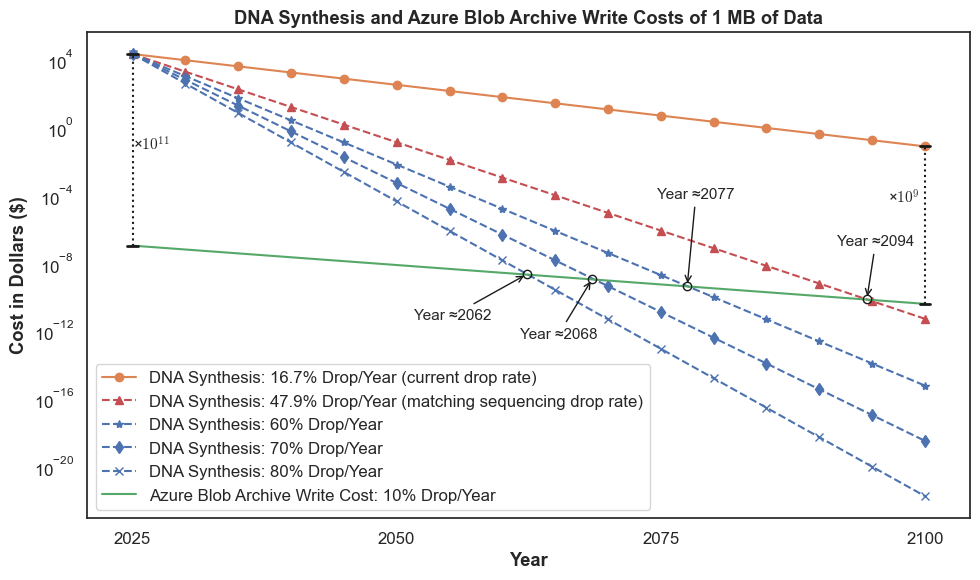

In [3]:
markers = {0.1671: 'o', 0.4791: "^", 0.6: "*", 0.7: "d", 0.8: "x"}
anchor_year = 2025
delta = 75
start_year = anchor_year
end_year = start_year + delta
years = list(range(start_year, end_year + 1))

palette = sns.color_palette("deep")

# create a figure/axes to ensure all plots go to the same Axes
fig, ax = plt.subplots(figsize=(10, 6))
#fig, ax = plt.subplots(figsize=(8, 5))

df = get_df_fig2()
for drop_rate in [0.1671, 0.4791, 0.6, 0.7, 0.8]:
    pct = f"{drop_rate*100:.1f}".rstrip('0').rstrip('.')

    if drop_rate == 0.1671:
        ax.plot(
            years,
            df[(df['isRealTrend']) & (df['Cost'] == 'Synthesis') & (df['Year'] >= start_year) &  (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            label=f"DNA Synthesis: {pct}% Drop/Year (current drop rate)",
            color=palette[1],
            marker=markers[drop_rate],
            markevery=5,
            #linewidth=2
        )

    elif drop_rate == 0.4791:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Synthesis') & (df['Year'] >= start_year) &  (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            label=f"DNA Synthesis: {pct}% Drop/Year (matching sequencing drop rate)",
            color=palette[3],
            linestyle='--',
            marker=markers[drop_rate],
            markevery=5,
            #linewidth=2
        )

    else:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Synthesis') & (df['Year'] >= start_year) &  (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            linestyle='--',
            color=palette[0],
            marker=markers[drop_rate],
            markevery=5,
            label=f"DNA Synthesis: {pct}% Drop/Year"
        )

tape_model = storage_service.azure(drop_rate=0.1)
cost_tape = [float(tape_model.cost_write.subs(Symbol('t', integer=True), year).doit()) for year in years]
plt.plot(years, cost_tape, color=sns.color_palette("deep")[2], label='Azure Blob Archive Write Cost: 10% Drop/Year', marker="", markevery=3)




########################################################################################################################################
# turn lists into np arrays
years = np.array(years)
tape_np  = np.array(cost_tape)
dna_np   = np.array([synthesis_cost_updated(year, drop_rate=0.4791, anchor_year=anchor_year) for year in years])

# 1) find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# optionally do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+5, cost_cross*1000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='bottom',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([synthesis_cost_updated(year, drop_rate=0.6, anchor_year=anchor_year) for year in years])

# 1) find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# optionally do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+5, cost_cross*100000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='bottom',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([synthesis_cost_updated(year, drop_rate=0.7, anchor_year=anchor_year) for year in years])

# 1) find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# optionally do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+1, cost_cross/700),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn your lists into arrays
years = np.array(years)
tape_np  = np.array(cost_tape)
dna_np   = np.array([synthesis_cost_updated(year, drop_rate=0.8, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross+0.3, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.3, cost_cross),
            xytext=(year_cross-3, cost_cross/100),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################




#### orders of magnitude
################################################################################################################
year_25 = 2025
i = 0
y_sequencing = cost_tape[i]
y_synthesis  = synthesis_cost_updated(year_25, anchor_year=anchor_year)


# stem 2025 between the lines
plt.plot([year_25, year_25],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)


# label 2025
factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_25,
         (y_sequencing + y_synthesis) / 200000,
        rf"×$10^{{{order_25}}}$",
         va='center',
         ha='left',
         fontsize=11)

#################################
################################################################################################################
#### orders of magnitude
################################################################################################################
year_100 = 2100
i = 2100 - anchor_year
y_sequencing = cost_tape[i]
y_synthesis  = synthesis_cost_updated(year_100, anchor_year=anchor_year)


# stem 2100 between the lines
plt.plot([year_100, year_100],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)



factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_100 - 0.5,
         (y_sequencing + y_synthesis) / 1000,
        rf"×$10^{{{abs(order_25)}}}$",
         va='center',
         ha='right',
         fontsize=11)

#################################
################################################################################################################

# Finish styling on the Axes
ax.legend(title=None)
ax.set_yscale('log')
ax.set_xlabel('Year',  fontweight="bold")
ax.set_ylabel('Cost in Dollars ($)', fontweight="bold")
ax.set_title(
    "DNA Synthesis and Azure Blob Archive Write Costs of 1 MB of Data",
    fontweight="bold"
)
plt.tight_layout()
plt.xticks([2025, 2050, 2075, 2100])

plt.show()


## Supplementary Figure 1b

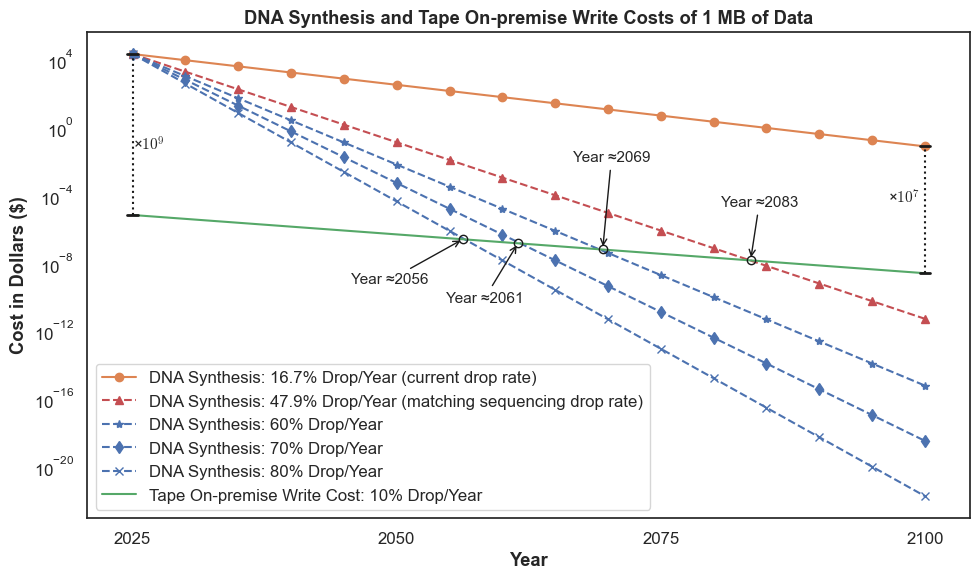

In [4]:
markers = {0.1671: 'o', 0.4791: "^", 0.6: "*", 0.7: "d", 0.8: "x"}
anchor_year = 2025
delta = 75
start_year = anchor_year
end_year = start_year + delta
years = list(range(start_year, end_year + 1))

palette = sns.color_palette("deep")

# create a figure/axes to ensure all plots go to the same Axes
fig, ax = plt.subplots(figsize=(10, 6))
#fig, ax = plt.subplots(figsize=(8, 5))
df = get_df_fig2()
for drop_rate in [0.1671, 0.4791, 0.6, 0.7, 0.8]:
    pct = f"{drop_rate*100:.1f}".rstrip('0').rstrip('.')

    if drop_rate == 0.1671:
        ax.plot(
            years,
            df[(df['isRealTrend']) & (df['Cost'] == 'Synthesis') & (df['Year'] >= start_year) &  (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            label=f"DNA Synthesis: {pct}% Drop/Year (current drop rate)",
            color=palette[1],
            marker=markers[drop_rate],
            markevery=5,
            #linewidth=2
        )

    elif drop_rate == 0.4791:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Synthesis') & (df['Year'] >= start_year) &  (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            label=f"DNA Synthesis: {pct}% Drop/Year (matching sequencing drop rate)",
            color=palette[3],
            linestyle='--',
            marker=markers[drop_rate],
            markevery=5,
            #linewidth=2
        )

    else:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Synthesis') & (df['Year'] >= start_year) &  (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            linestyle='--',
            color=palette[0],
            marker=markers[drop_rate],
            markevery=5,
            label=f"DNA Synthesis: {pct}% Drop/Year"
        )

tape_m = storage_service.tape_on_premise(improv_rate_per_year=0.1)
cost_tape = [float(tape_m.cost_write.subs(Symbol('t', integer=True), year).doit()) for year in years]
plt.plot(years, cost_tape, color=sns.color_palette("deep")[2], label='Tape On-premise Write Cost: 10% Drop/Year', marker="", markevery=3)




########################################################################################################################################
# turn lists into np arrays
years = np.array(years)
tape_np  = np.array(cost_tape)
dna_np   = np.array([synthesis_cost_updated(year, drop_rate=0.4791, anchor_year=anchor_year) for year in years])

# 1) find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# optionally do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+5, cost_cross*1000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='bottom',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([synthesis_cost_updated(year, drop_rate=0.6, anchor_year=anchor_year) for year in years])

# 1) find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# optionally do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+5, cost_cross*100000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='bottom',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np = np.array([synthesis_cost_updated(year, drop_rate=0.7, anchor_year=anchor_year) for year in years])

# 1) find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# optionally do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+1, cost_cross/700),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([synthesis_cost_updated(year, drop_rate=0.8, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.3, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.3, cost_cross),
            xytext=(year_cross-3, cost_cross/100),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################




#### orders of magnitude
################################################################################################################
year_25 = 2025
i = 0
y_sequencing = cost_tape[i]
y_synthesis  = synthesis_cost_updated(year_25, anchor_year=anchor_year)


# stem 2025 between the lines
plt.plot([year_25, year_25],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)


# label 2025
factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_25,
         (y_sequencing + y_synthesis) / 200000,
        rf"×$10^{{{order_25}}}$",
         va='center',
         ha='left',
         fontsize=11)

#################################
################################################################################################################
#### orders of magnitude
################################################################################################################
year_100 = 2100
i = 2100 - anchor_year
y_sequencing = cost_tape[i]
y_synthesis  = synthesis_cost_updated(year_100, anchor_year=anchor_year)


# stem 2100 between the lines
plt.plot([year_100, year_100],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)



factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_100 - 0.5,
         (y_sequencing + y_synthesis) / 1000,
        rf"×$10^{{{abs(order_25)}}}$",
         va='center',
         ha='right',
         fontsize=11)

#################################
################################################################################################################

# Finish styling on the Axes
ax.legend(title=None)
ax.set_yscale('log')
ax.set_xlabel('Year',  fontweight="bold")
ax.set_ylabel('Cost in Dollars ($)', fontweight="bold")
ax.set_title(
    "DNA Synthesis and Tape On-premise Write Costs of 1 MB of Data",
    fontweight="bold"
)
plt.tight_layout()
plt.xticks([2025, 2050, 2075, 2100])

plt.show()


## Supplementary Figure 2a

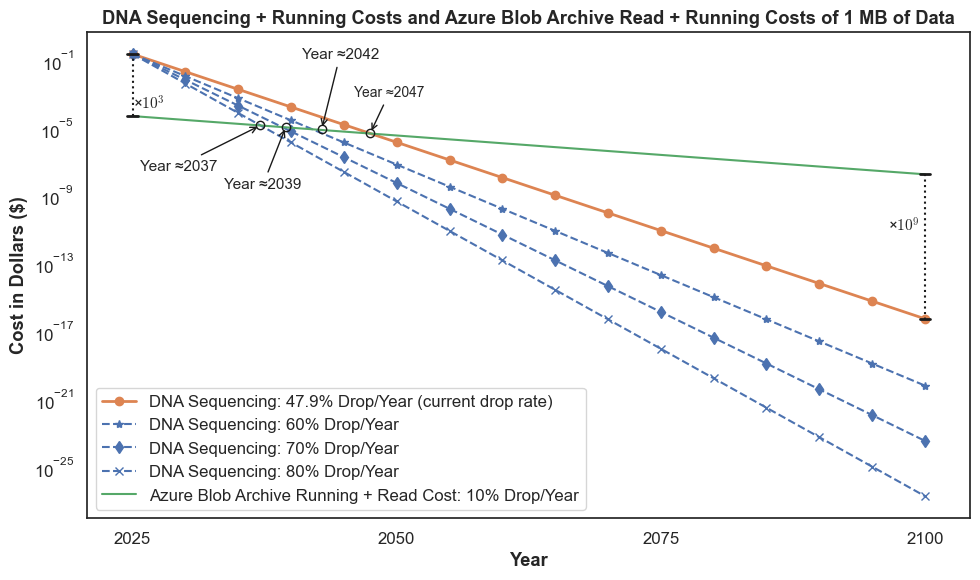

In [5]:
markers = {0.4791: 'o', 0.6: "*", 0.7: "d", 0.8: "x"}
anchor_year = 2025
tape_c_model = storage_service.tape_on_premise(0.1)
delta = 75
start_year = anchor_year
end_year = start_year + delta
years = list(range(start_year, end_year + 1))


palette = sns.color_palette("deep")

fig, ax = plt.subplots(figsize=(10, 6))
#fig, ax = plt.subplots(figsize=(8, 5))
df = get_df_fig2()
for drop_rate in [0.4791, 0.6, 0.7, 0.8]:
    pct = f"{drop_rate*100:.1f}".rstrip('0').rstrip('.')

    if drop_rate == 0.4791:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Sequencing') & (df['Year'] >= start_year) & (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            label=f"DNA Sequencing: {pct}% Drop/Year (current drop rate)",
            color=palette[1],
            linewidth=2,
            marker=markers[drop_rate],
            markevery=5,
        )

    else:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Sequencing') & (df['Year'] >= start_year) & (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            linestyle='--',
            color=palette[0],
            marker=markers[drop_rate],
            markevery=5,
            label=f"DNA Sequencing: {pct}% Drop/Year"
        )

drop_rate = 0.1
tape_c_model = storage_service.azure(drop_rate=drop_rate)
tape_cost_list = [float((tape_c_model.cost_read + tape_c_model.cost_maint).subs(Symbol('t', integer=True), year).doit()) for year in years]
plt.plot(years,
         tape_cost_list,
         color=sns.color_palette("deep")[2],
         label=f'Azure Blob Archive Running + Read Cost: {drop_rate * 100:.2f}'.rstrip('0').rstrip('.') + '% Drop/Year', marker="", markevery=3
         )

########################################################################################################################################
# turn lists into np arrays
years = np.array(years)
tape_np  = np.array(tape_cost_list)
dna_np   = np.array([sequencing_cost_updated(year, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# optionally do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross-1, cost_cross*100),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='left', va='bottom',
            #bbox=dict(
            #    boxstyle='round,pad=0.5',
            #    edgecolor='black',
            #    facecolor='white',
            #    linestyle='-',
            #    linewidth=1
            #),
            fontsize=10)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([sequencing_cost_updated(year, drop_rate=0.6, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.9, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.9, cost_cross),
            xytext=(year_cross-1, cost_cross*10000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='left', va='bottom',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([sequencing_cost_updated(year, drop_rate=0.7, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+2, cost_cross/1000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([sequencing_cost_updated(year, drop_rate=0.8, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.1, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.1, cost_cross),
            xytext=(year_cross-4, cost_cross/100),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################
#### orders of magnitude
################################################################################################################
year_25 = 2025
i = 0
y_sequencing = tape_cost_list[i]
y_synthesis  = sequencing_cost_updated(year_25, anchor_year=anchor_year)


# stem 2025 between the lines
plt.plot([year_25, year_25],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)


# label 2025
factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_25,
         (y_sequencing + y_synthesis) / 800,
        rf"×$10^{{{order_25}}}$",
         va='center',
         ha='left',
         fontsize=11)

#################################
################################################################################################################
#### orders of magnitude
################################################################################################################
year_100 = 2100
i = 2100 - anchor_year
y_sequencing = tape_cost_list[i]
y_synthesis  = sequencing_cost_updated(year_100, anchor_year=anchor_year)


# stem 2100 between the lines
plt.plot([year_100, year_100],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)



factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_100 - 0.5,
         (y_sequencing + y_synthesis) / 1000,
        rf"×$10^{{{abs(order_25)}}}$",
         va='center',
         ha='right',
         fontsize=11)

#################################
################################################################################################################


ax.legend(title=None, loc='lower left')
ax.set_yscale('log')
ax.set_xlabel('Year',  fontweight="bold")
ax.set_ylabel('Cost in Dollars ($)', fontweight="bold")
ax.set_title(
    "DNA Sequencing + Running Costs and Azure Blob Archive Read + Running Costs of 1 MB of Data",
    fontweight="bold"
)
plt.xticks([2025, 2050, 2075, 2100])
plt.tight_layout()
plt.show()


## Supplementary Figure 2b

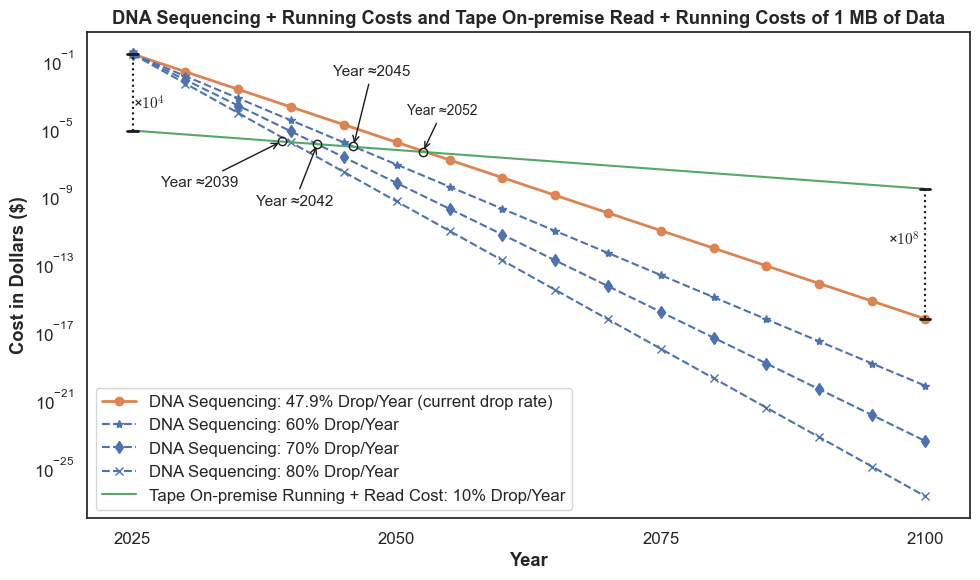

In [6]:
markers = {0.4791: 'o', 0.6: "*", 0.7: "d", 0.8: "x"}
anchor_year = 2025
tape_storage_model = storage_service.tape_on_premise(0.1)
delta = 75
start_year = anchor_year
end_year = start_year + delta
years = list(range(start_year, end_year + 1))

palette = sns.color_palette("deep")

# create a figure/axes to ensure all plots go to the same Axes
fig, ax = plt.subplots(figsize=(10, 6))
#fig, ax = plt.subplots(figsize=(8, 5))
df = get_df_fig2()
for drop_rate in [0.4791, 0.6, 0.7, 0.8]:
    pct = f"{drop_rate*100:.1f}".rstrip('0').rstrip('.')

    if drop_rate == 0.4791:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Sequencing') & (df['Year'] >= start_year) & (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            label=f"DNA Sequencing: {pct}% Drop/Year (current drop rate)",
            color=palette[1],
            linewidth=2,
            marker=markers[drop_rate],
            markevery=5,
        )

    else:
        ax.plot(
            years,
            df[(df['Trend'] == drop_rate) & (df['Cost'] == 'Sequencing') & (df['Year'] >= start_year) & (df['Year'] <= end_year) & (df['Anchor Year'] == anchor_year)]['Value'],
            linestyle='--',
            color=palette[0],
            marker=markers[drop_rate],
            markevery=5,
            label=f"DNA Sequencing: {pct}% Drop/Year"
        )

drop_rate = 0.1
tape_storage_model = storage_service.tape_on_premise(improv_rate_per_year=drop_rate)
cost_per_year_list = [float((tape_storage_model.cost_read + tape_storage_model.cost_maint).subs(Symbol('t', integer=True), year).doit()) for year in years]
plt.plot(years,
         cost_per_year_list,
         color=sns.color_palette("deep")[2],
         label=f'Tape On-premise Running + Read Cost: {drop_rate * 100:.2f}'.rstrip('0').rstrip('.') + '% Drop/Year', marker="", markevery=3
         )

########################################################################################################################################
# turn lists into np arrays
years = np.array(years)
tape_np  = np.array(cost_per_year_list)
dna_np   = np.array([sequencing_cost_updated(year, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross-1, cost_cross*100),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='left', va='bottom',
            #bbox=dict(
            #    boxstyle='round,pad=0.5',
            #    edgecolor='black',
            #    facecolor='white',
            #    linestyle='-',
            #    linewidth=1
            #),
            fontsize=10)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([sequencing_cost_updated(year, drop_rate=0.6, anchor_year=anchor_year) for year in years])

# 1find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.9, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.9, cost_cross),
            xytext=(year_cross-1, cost_cross*10000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='left', va='bottom',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([sequencing_cost_updated(year, drop_rate=0.7, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.5, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.5, cost_cross),
            xytext=(year_cross+2, cost_cross/1000),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################
########################################################################################################################################
# turn lists into np arrays
dna_np   = np.array([sequencing_cost_updated(year, drop_rate=0.8, anchor_year=anchor_year) for year in years])

# find the first index where DNA <= Tape
cross_idx = np.where(dna_np <= tape_np)[0][0]

# do a linear interpolation in log-space to refine the exact year
t0, t1 = years[cross_idx-1], years[cross_idx]
y0_t, y1_t = tape_np[cross_idx-1], tape_np[cross_idx]
y0_d, y1_d = dna_np[cross_idx-1], dna_np[cross_idx]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = int(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# mark it
ax.plot(year_cross+0.1, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

ax.annotate(f"Year ≈{year_cross:.0f}",
            xy=(year_cross+0.1, cost_cross),
            xytext=(year_cross-4, cost_cross/100),
            arrowprops=dict(arrowstyle="->", lw=1, color='k'),
            ha='right', va='top',
            fontsize=11)

#########################################################################################################################################
#### orders of magnitude
################################################################################################################
year_25 = 2025
i = 0
y_sequencing = cost_per_year_list[i]
y_synthesis  = sequencing_cost_updated(year_25, anchor_year=anchor_year)


# stem 2025 between the lines
plt.plot([year_25, year_25],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2025
plt.plot([year_25 - 0.5, year_25 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)


# label 2025
factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_25,
         (y_sequencing + y_synthesis) / 800,
        rf"×$10^{{{order_25}}}$",
         va='center',
         ha='left',
         fontsize=11)

#################################
################################################################################################################
#### orders of magnitude
################################################################################################################
year_100 = 2100
i = 2100 - anchor_year
y_sequencing = cost_per_year_list[i]
y_synthesis  = sequencing_cost_updated(year_100, anchor_year=anchor_year)


# stem 2100 between the lines
plt.plot([year_100, year_100],
         [y_sequencing, y_synthesis],
         color='k',
         linewidth=1.5,
         linestyle=':')



# bottom cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_sequencing, y_sequencing],
        color='k',
        linewidth=2)

# top cap 2100
plt.plot([year_100 - 0.5, year_100 + 0.5],
        [y_synthesis, y_synthesis],
        color='k',
        linewidth=2)



factor25 = y_synthesis / y_sequencing
factor25_log10_val = math.log10(factor25)
order_25 = math.floor(factor25_log10_val)
plt.text(year_100 - 0.5,
         (y_sequencing + y_synthesis) / 1000,
        rf"×$10^{{{abs(order_25)}}}$",
         va='center',
         ha='right',
         fontsize=11)

#################################
################################################################################################################


ax.legend(title=None, loc='lower left')
ax.set_yscale('log')
ax.set_xlabel('Year',  fontweight="bold")
ax.set_ylabel('Cost in Dollars ($)', fontweight="bold")
ax.set_title(
    "DNA Sequencing + Running Costs and Tape On-premise Read + Running Costs of 1 MB of Data",
    fontweight="bold"
)
plt.xticks([2025, 2050, 2075, 2100])
plt.tight_layout()
plt.show()


## Supplementary Figure 3a

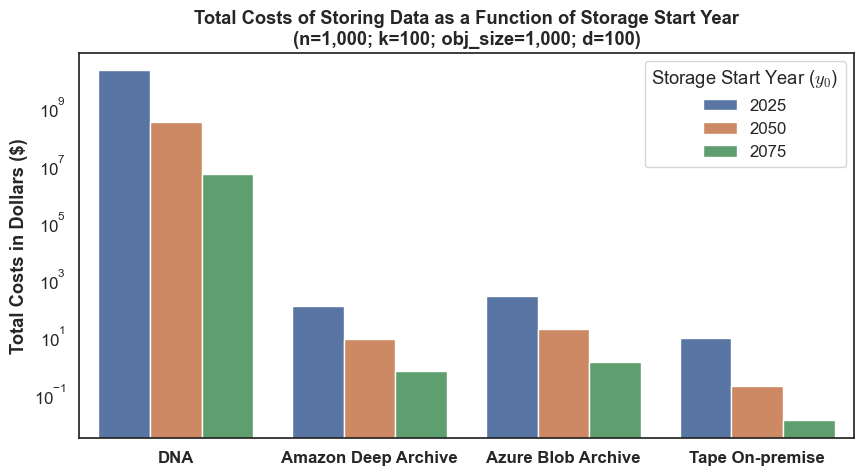

In [18]:
plt.figure(figsize=(10, 5))
n = 1000
k = 100
obj_size = 1000
d = 100

g = sns.barplot(
    data=get_df_fig3(k=k),
    x="Storage",
    y="Cost",
    hue="Year",
    palette="deep",
)
plt.yscale("log")
plt.title(
    f"Total Costs of Storing Data as a Function of Storage Start Year\n"
    f"(n={n:,}; k={k:,}; obj_size={obj_size:,}; d={d})",
    fontweight="bold"
)
plt.legend(title="Storage Start Year ($y_0$)")
#plt.xticks(rotation=45)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.ylabel("Total Costs in Dollars ($)", fontweight="bold")
#plt.xlabel(xlabel="Storage Approach", fontweight="bold")
plt.xlabel(None)
ax = plt.gca()

for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')
#plt.tight_layout()

plt.show()

## Supplementary Figure 3b

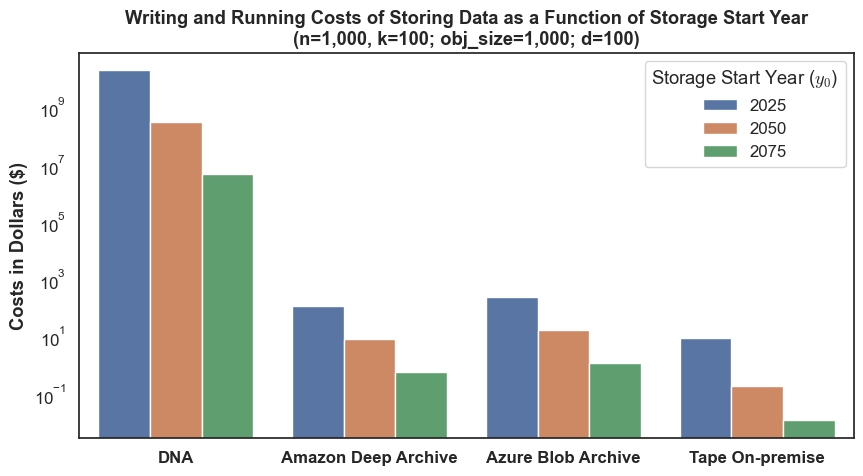

In [9]:
plt.figure(figsize=(10, 5))
n = 1000
k = 100
obj_size = 1000
d = 100
g = sns.barplot(
    data=get_df_fig3(k=k),
    x="Storage",
    y="Cost Write+Run",
    hue="Year",
    palette="deep",
)
plt.yscale("log")
plt.title(
    f"Writing and Running Costs of Storing Data as a Function of Storage Start Year\n"
    f"(n={n:,}, k={k:,}; obj_size={obj_size:,}; d={d})",
    fontweight="bold"
)
plt.legend(title="Storage Start Year ($y_0$)")
#plt.xticks(rotation=45)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.ylabel("Costs in Dollars ($)", fontweight="bold")
#plt.xlabel(xlabel="Storage Approach", fontweight="bold")
plt.xlabel(None)
#plt.tight_layout()
ax = plt.gca()

for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')

plt.show()

## Supplementary Figure 3c

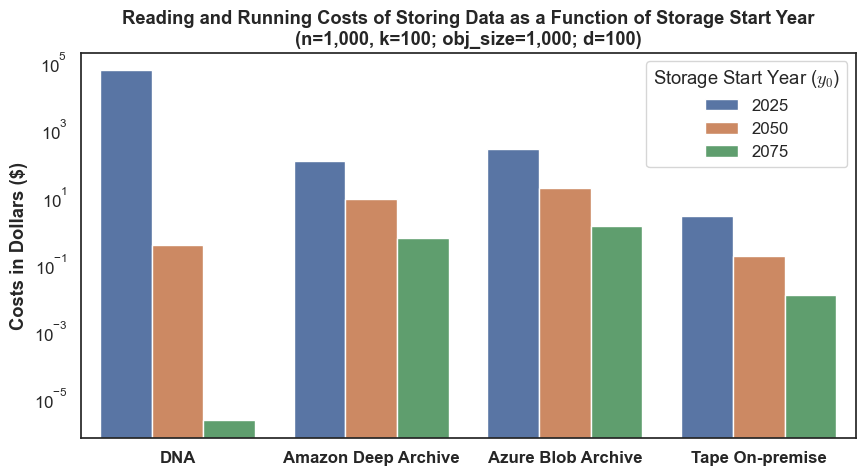

In [23]:
n = 1000
k = 100
obj_size = 1000
d = 100
plt.figure(figsize=(10, 5))
g = sns.barplot(
    data=get_df_fig3(k=k),
    x="Storage",
    y="Cost Read+Run",
    hue="Year",
    palette="deep",
)
plt.yscale("log")
plt.title(
    f"Reading and Running Costs of Storing Data as a Function of Storage Start Year\n"
    f"(n={n:,}, k={k:,}; obj_size={obj_size:,}; d={d})",
    fontweight="bold"
)
plt.legend(title="Storage Start Year ($y_0$)")
#plt.xticks(rotation=45)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.ylabel("Costs in Dollars ($)", fontweight="bold")
#plt.xlabel(xlabel="Storage Approach", fontweight="bold")
plt.xlabel(None)
#plt.tight_layout()
ax = plt.gca()
for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')

plt.show()

## Supplementary Figure 4a

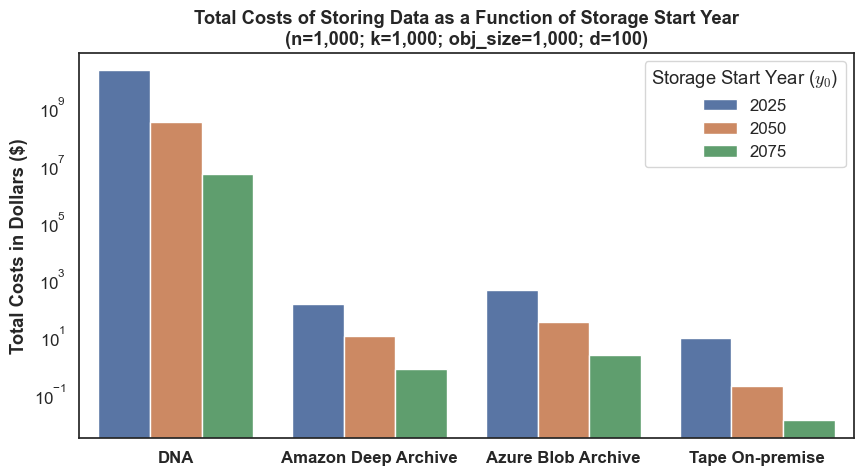

In [17]:
plt.figure(figsize=(10, 5))
n = 1000
k = 1000
obj_size = 1000
d = 100

g = sns.barplot(
    data=get_df_fig3(k=k),
    x="Storage",
    y="Cost",
    hue="Year",
    palette="deep",
)
plt.yscale("log")
plt.title(
    f"Total Costs of Storing Data as a Function of Storage Start Year\n"
    f"(n={n:,}; k={k:,}; obj_size={obj_size:,}; d={d})",
    fontweight="bold"
)
plt.legend(title="Storage Start Year ($y_0$)")
#plt.xticks(rotation=45)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.ylabel("Total Costs in Dollars ($)", fontweight="bold")
#plt.xlabel(xlabel="Storage Approach", fontweight="bold")
plt.xlabel(None)
ax = plt.gca()

for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')
#plt.tight_layout()

plt.show()

## Supplementary Figure 4b

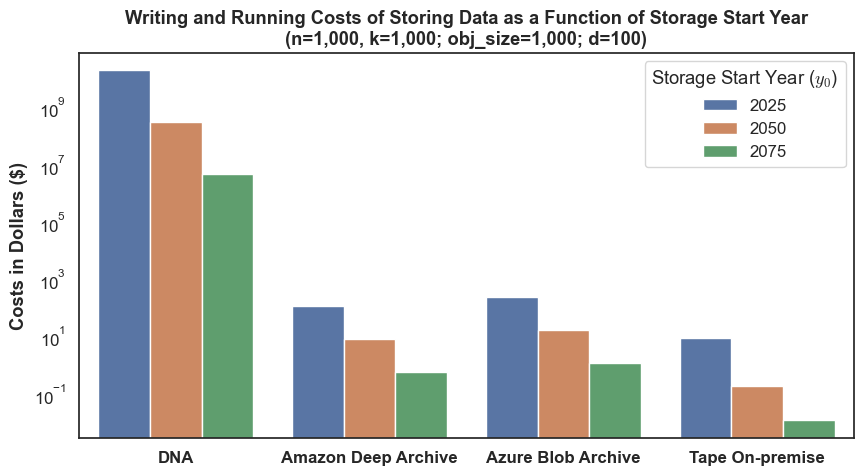

In [19]:
plt.figure(figsize=(10, 5))
n = 1000
k = 1000
obj_size = 1000
d = 100
g = sns.barplot(
    data=get_df_fig3(k=k),
    x="Storage",
    y="Cost Write+Run",
    hue="Year",
    palette="deep",
)
plt.yscale("log")
plt.title(
    f"Writing and Running Costs of Storing Data as a Function of Storage Start Year\n"
    f"(n={n:,}, k={k:,}; obj_size={obj_size:,}; d={d})",
    fontweight="bold"
)
plt.legend(title="Storage Start Year ($y_0$)")
#plt.xticks(rotation=45)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.ylabel("Costs in Dollars ($)", fontweight="bold")
#plt.xlabel(xlabel="Storage Approach", fontweight="bold")
plt.xlabel(None)
#plt.tight_layout()
ax = plt.gca()

for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')

plt.show()

## Supplementary Figure 4c

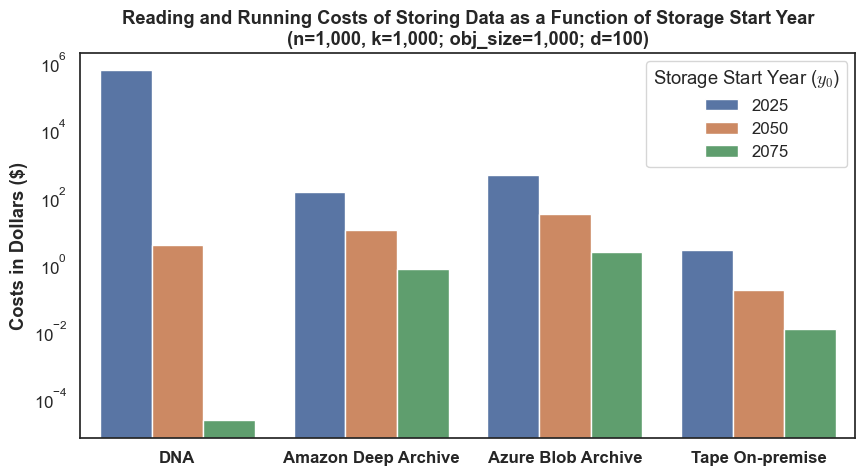

In [24]:
n = 1000
k = 1000
obj_size = 1000
d = 100
plt.figure(figsize=(10, 5))
g = sns.barplot(
    data=get_df_fig3(k=k),
    x="Storage",
    y="Cost Read+Run",
    hue="Year",
    palette="deep",
)
plt.yscale("log")
plt.title(
    f"Reading and Running Costs of Storing Data as a Function of Storage Start Year\n"
    f"(n={n:,}, k={k:,}; obj_size={obj_size:,}; d={d})",
    fontweight="bold"
)
plt.legend(title="Storage Start Year ($y_0$)")
#plt.xticks(rotation=45)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

plt.ylabel("Costs in Dollars ($)", fontweight="bold")
#plt.xlabel(xlabel="Storage Approach", fontweight="bold")
plt.xlabel(None)
#plt.tight_layout()
ax = plt.gca()
for lbl in ax.get_xticklabels():
    lbl.set_fontweight('bold')

plt.show()

## Supplementary Figure 5a

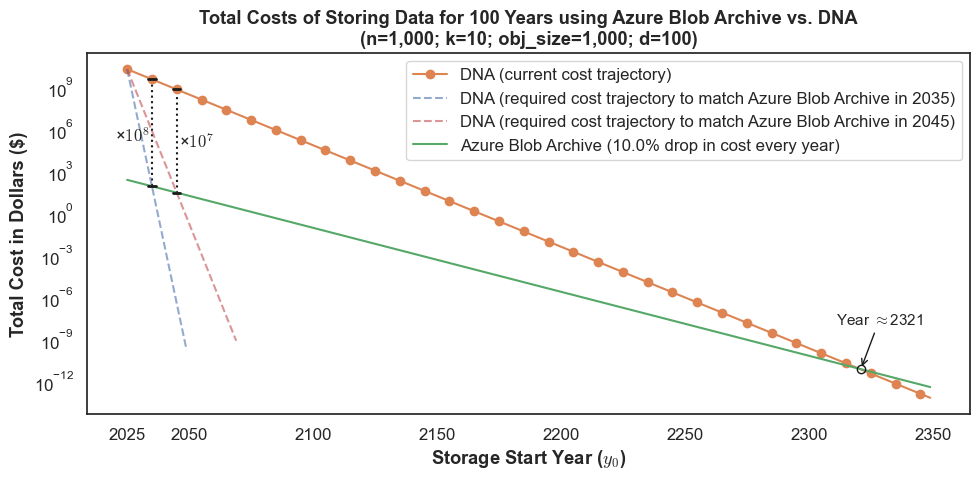

In [25]:
n = 1_000
k = 10
obj_size = 1000
d = 100

anchor_year = 2025
cost_amazon_tape = {}
cost_tape = {}
cost_dna = {}
cost_dna_op_45 = {}
cost_dna_op_35 = {}

begin_year = 2025
end_year = 2350
x = list(range(begin_year, end_year))

start_year_symbol = Symbol('start_year', integer=True)

dna_model = storage_service.dna(n=n, k=k, d=d, obj_size_mb=obj_size, start_year=start_year_symbol, synthesis_anchor_year=anchor_year, sequencing_anchor_year=anchor_year)


improv_percent_amazon_tape = 0.1
azure_model = storage_service.azure(n=n, k=k, d=d, obj_size_mb=obj_size, start_year=start_year_symbol, drop_rate=improv_percent_amazon_tape)

improv_percent_tape = 0.1
tape_model = storage_service.tape_on_premise(n=n, k=d, obj_size_mb=obj_size, d=d, start_year=start_year_symbol, improv_rate_per_year=improv_percent_tape)
#tape_model = storage_service.tape_on_premise_updated(n=n, k=d, obj_size_mb=obj_size, d=d, start_year=start_year_symbol)


#amazon_model = tape_model###############################################################################################################################################################################
year_35 = 2035
year_45 = 2045
#curve_25 = float(tape.eval().subs(year_symbol, 2025).doit()) / float(dna.eval().subs(year_symbol, 2000).doit()) * t + float(dna.eval().subs(year_symbol, 2020).doit())
curve_45 = make_exponential(anchor_year - 2000, float(dna_model.eval().subs(start_year_symbol, anchor_year).doit()), year_45 - 2000, float(azure_model.eval().subs(start_year_symbol, year_45).doit()))

#curve_35 = float(tape.eval().subs(year_symbol, 2035).doit()) / float(dna.eval().subs(year_symbol, 2000).doit()) * t + float(dna.eval().subs(year_symbol, 2035).doit())
curve_35 = make_exponential(anchor_year - 2000, float(dna_model.eval().subs(start_year_symbol, anchor_year).doit()), year_35 - 2000, float(azure_model.eval().subs(start_year_symbol, year_35).doit()))

missing_years_left = anchor_year - begin_year
missing_years_right_35 = 300
missing_years_right_45 = 280
last_year_for_35 = end_year - missing_years_right_35
last_year_for_45 = end_year - missing_years_right_45

for year in x:
    dna_model.start_year    = year
    azure_model.start_year = year
    tape_model.start_year   = year

    cost_amazon_tape[year] = float(azure_model.eval())
    cost_tape[year] = float(tape_model.eval())
    cost_dna[year] = float(dna_model.eval())
    #cost_dna_op_25.append(float(curve_25.subs(t, year).doit()))
    if year < last_year_for_35 and year >= anchor_year:
        #cost_dna_op_45[year] = float(curve_45(year - 2000))
        cost_dna_op_35[year] = float(curve_35(year - 2000))
    if year < last_year_for_45 and year >= anchor_year:
        cost_dna_op_45[year] = float(curve_45(year - 2000))
        #cost_dna_op_35[year] = float(curve_35(year - 2000))
    #cost_dna_op_35.append(float(curve_35.subs(t, year).doit()))

################################

# Make the figure bigger
plt.figure(figsize=(10, 5))

ax = plt.gca()

# Original 2045 cap-style marker
cap_width = 0.0

y_b45 = cost_amazon_tape[year_45]
y_t45 = cost_dna[year_45]
x0_45, x1_45 = year_45 - cap_width / 2, year_45 + cap_width / 2




# stem 2045
ax.plot([year_45, year_45],
        [y_b45, y_t45],
        color='k',
        linewidth=1.5,
        linestyle=':')



# label 2045
factor45 = cost_dna[year_45] / cost_amazon_tape[year_45]
factor45_log10_val = math.log10(factor45)
order_45 = round(factor45_log10_val)
ax.text(x1_45 + 1,
        (y_b45 + y_t45) / 5000,
        rf"×$10^{{{order_45}}}$",
        va='center',
        ha='left',
        fontsize=12)

# new 2035 cap-style marker
year_35 = 2035
y_b35 = cost_amazon_tape[year_35]
y_t35 = cost_dna[year_35]
x0_35, x1_35 = year_35 - cap_width/2, year_35 + cap_width/2



# stem 2035
ax.plot([year_35, year_35],
        [y_b35, y_t35],
        color='k',
        linewidth=1.5,
        linestyle=':')

# label 2035
factor35 = cost_dna[year_35] / cost_amazon_tape[year_35]
factor35_log10_val = math.log10(factor35)
order_35 = round(factor35_log10_val)
ax.text(x1_35 - 15,
        (y_b35 + y_t35) / 10000,
        rf"×$10^{{{order_35}}}$",
        va='center',
        ha='left',
        fontsize=12)

#################################



#plt.plot(x, cost_tape, label=f"Tape On-Premise ({improv_percent_tape * 100}% drop in cost every year)")
plt.plot(x, [cost_dna[year] for year in x], label="DNA (current cost trajectory)", color=sns.color_palette("deep")[1], marker='o', markevery=10)
plt.plot(x[missing_years_left:-missing_years_right_35], [cost_dna_op_35[year] for year in x[missing_years_left:-missing_years_right_35]], label="DNA (required cost trajectory to match Azure Blob Archive in 2035)", linestyle="--", color=sns.color_palette("deep")[0], alpha=0.6, marker='', markevery=4)
plt.plot(x[missing_years_left:-missing_years_right_45], [cost_dna_op_45[year] for year in x[missing_years_left:-missing_years_right_45]], label="DNA (required cost trajectory to match Azure Blob Archive in 2045)", linestyle="--", color=sns.color_palette("deep")[3], alpha=0.6, marker='', markevery=7)
plt.plot(x, [cost_amazon_tape[year] for year in x], label=f"Azure Blob Archive ({improv_percent_amazon_tape * 100}% drop in cost every year)", color=sns.color_palette("deep")[2])
######
# bottom cap 2035
ax.plot([year_35 - 1.5, year_35 + 1.5],
        [y_b35, y_b35],
        color='k',
        linewidth=2)

# top cap 2035
ax.plot([year_35 - 1.5, year_35 + 1.5],
        [y_t35, y_t35],
        color='k',
        linewidth=2)
# bottom cap 2045
ax.plot([year_45 - 1.5, year_45 + 1.5],
        [y_b45, y_b45],
        color='k',
        linewidth=2)

# top cap 2045
ax.plot([year_45 - 1.5, year_45 + 1.5],
        [y_t45, y_t45],
        color='k',
        linewidth=2)
###########
plt.yscale('log')
plt.legend()
#plt.legend(loc='lower left')
plt.title(
    f"Total Costs of Storing Data for {d:,} Years using Azure Blob Archive vs. DNA\n"
    f"(n={n:,}; k={k}; obj_size={obj_size:,}; d={d:,})",
    fontweight="bold"
)
plt.xlabel(r'Storage Start Year ($\boldsymbol{y_0}$)', fontweight="bold")
plt.ylabel('Total Cost in Dollars ($)', fontweight="bold")

#leg = plt.legend(
#    loc='upper left',
#    bbox_to_anchor=(1.02, 1),
#    borderaxespad=0.0
#)
#######################################################################################################

years = x

# find the first index where DNA <= Tape
dna_tape_match_year = None
for year in years:
    if cost_dna[year] <= cost_amazon_tape[year]:
        dna_tape_match_year = year
        break


# do a linear interpolation in log-space to refine the exact year
t0, t1 = dna_tape_match_year - 1, dna_tape_match_year
y0_t, y1_t = cost_amazon_tape[dna_tape_match_year-1], cost_amazon_tape[dna_tape_match_year]
y0_d, y1_d = cost_dna[dna_tape_match_year-1], cost_dna[dna_tape_match_year]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = math.ceil(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

# annotate it
#ax.annotate(f"Year ≈{year_cross:.0f}",
#            xy=(year_cross, cost_cross),
#            xytext=(year_cross-2, cost_cross/2/10),
#            arrowprops=dict(arrowstyle="->", lw=1),
#            ha='left', va='top',
#            fontsize=10)

ax.annotate(fr"Year $\approx${year_cross:.0f}",
            xy=(year_cross, cost_cross),
            xytext=(year_cross-10, cost_cross*10*100),
            arrowprops=dict(arrowstyle='->', lw=1, color='k'),
            ha='left', va='bottom',
            fontsize=11)

#######################################################################################################
plt.tight_layout()
plt.xticks([2025, 2050, 2100, 2150, 2200, 2250, 2300, 2350])
plt.show()


## Supplementary Figure 5b

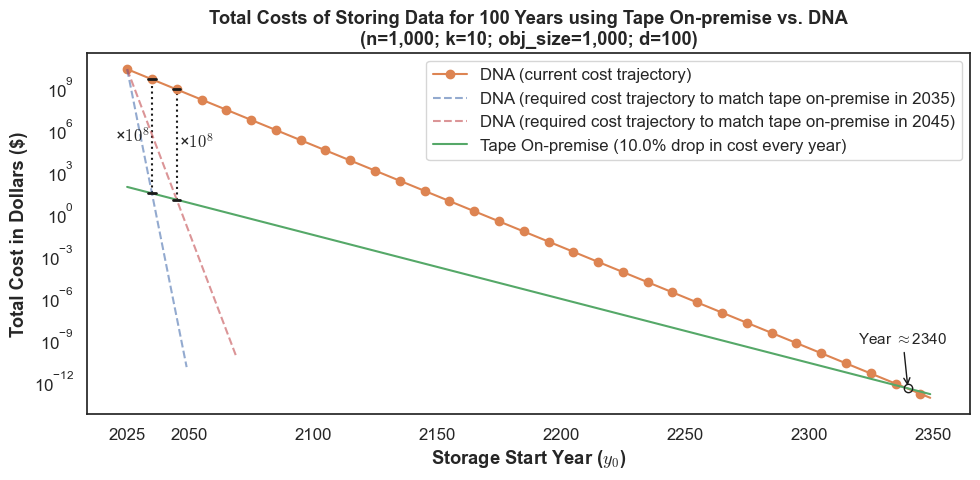

In [26]:
n = 1_000
k = 10
obj_size = 1000
d = 100

anchor_year = 2025
cost_amazon_tape = {}
cost_tape = {}
cost_dna = {}
cost_dna_op_45 = {}
cost_dna_op_35 = {}

begin_year = 2025
end_year = 2350
x = list(range(begin_year, end_year))

start_year_symbol = Symbol('start_year', integer=True)

dna_model = storage_service.dna(n=n, k=k, d=d, obj_size_mb=obj_size, start_year=start_year_symbol, synthesis_anchor_year=anchor_year, sequencing_anchor_year=anchor_year)


improv_percent_amazon_tape = 0.1
tape_on_prem_model = storage_service.tape_on_premise(n=n, k=k, d=d, obj_size_mb=obj_size, start_year=start_year_symbol, improv_rate_per_year=improv_percent_amazon_tape)

improv_percent_tape = 0.1
tape_model = storage_service.tape_on_premise(n=n, k=d, obj_size_mb=obj_size, d=d, start_year=start_year_symbol, improv_rate_per_year=improv_percent_tape)
#tape_model = storage_service.tape_on_premise_updated(n=n, k=d, obj_size_mb=obj_size, d=d, start_year=start_year_symbol)


#amazon_model = tape_model###############################################################################################################################################################################
year_35 = 2035
year_45 = 2045
#curve_25 = float(tape.eval().subs(year_symbol, 2025).doit()) / float(dna.eval().subs(year_symbol, 2000).doit()) * t + float(dna.eval().subs(year_symbol, 2020).doit())
curve_45 = make_exponential(anchor_year - 2000, float(dna_model.eval().subs(start_year_symbol, anchor_year).doit()), year_45 - 2000, float(tape_on_prem_model.eval().subs(start_year_symbol, year_45).doit()))

#curve_35 = float(tape.eval().subs(year_symbol, 2035).doit()) / float(dna.eval().subs(year_symbol, 2000).doit()) * t + float(dna.eval().subs(year_symbol, 2035).doit())
curve_35 = make_exponential(anchor_year - 2000, float(dna_model.eval().subs(start_year_symbol, anchor_year).doit()), year_35 - 2000, float(tape_on_prem_model.eval().subs(start_year_symbol, year_35).doit()))

missing_years_left = anchor_year - begin_year
missing_years_right_35 = 300
missing_years_right_45 = 280
last_year_for_35 = end_year - missing_years_right_35
last_year_for_45 = end_year - missing_years_right_45

for year in x:
    dna_model.start_year    = year
    tape_on_prem_model.start_year = year
    tape_model.start_year   = year

    cost_amazon_tape[year] = float(tape_on_prem_model.eval())
    cost_tape[year] = float(tape_model.eval())
    cost_dna[year] = float(dna_model.eval())
    #cost_dna_op_25.append(float(curve_25.subs(t, year).doit()))
    if year < last_year_for_35 and year >= anchor_year:
        #cost_dna_op_45[year] = float(curve_45(year - 2000))
        cost_dna_op_35[year] = float(curve_35(year - 2000))
    if year < last_year_for_45 and year >= anchor_year:
        cost_dna_op_45[year] = float(curve_45(year - 2000))
        #cost_dna_op_35[year] = float(curve_35(year - 2000))
    #cost_dna_op_35.append(float(curve_35.subs(t, year).doit()))

################################

# Make the figure bigger
plt.figure(figsize=(10, 5))

ax = plt.gca()

# Original 2045 cap-style marker
cap_width = 0.0

y_b45 = cost_amazon_tape[year_45]
y_t45 = cost_dna[year_45]
x0_45, x1_45 = year_45 - cap_width / 2, year_45 + cap_width / 2




# stem 2045
ax.plot([year_45, year_45],
        [y_b45, y_t45],
        color='k',
        linewidth=1.5,
        linestyle=':')



# label 2045
factor45 = cost_dna[year_45] / cost_amazon_tape[year_45]
factor45_log10_val = math.log10(factor45)
order_45 = round(factor45_log10_val)
ax.text(x1_45 + 1,
        (y_b45 + y_t45) / 5000,
        rf"×$10^{{{order_45}}}$",
        va='center',
        ha='left',
        fontsize=12)


year_35 = 2035
y_b35 = cost_amazon_tape[year_35]
y_t35 = cost_dna[year_35]
x0_35, x1_35 = year_35 - cap_width/2, year_35 + cap_width/2



# stem 2035
ax.plot([year_35, year_35],
        [y_b35, y_t35],
        color='k',
        linewidth=1.5,
        linestyle=':')

# label 2035
factor35 = cost_dna[year_35] / cost_amazon_tape[year_35]
factor35_log10_val = math.log10(factor35)
order_35 = round(factor35_log10_val)
ax.text(x1_35 - 15,
        (y_b35 + y_t35) / 10000,
        rf"×$10^{{{order_35}}}$",
        va='center',
        ha='left',
        fontsize=12)

#################################



#plt.plot(x, cost_tape, label=f"Tape On-Premise ({improv_percent_tape * 100}% drop in cost every year)")
plt.plot(x, [cost_dna[year] for year in x], label="DNA (current cost trajectory)", color=sns.color_palette("deep")[1], marker='o', markevery=10)
plt.plot(x[missing_years_left:-missing_years_right_35], [cost_dna_op_35[year] for year in x[missing_years_left:-missing_years_right_35]], label="DNA (required cost trajectory to match tape on-premise in 2035)", linestyle="--", color=sns.color_palette("deep")[0], alpha=0.6, marker='', markevery=4)
plt.plot(x[missing_years_left:-missing_years_right_45], [cost_dna_op_45[year] for year in x[missing_years_left:-missing_years_right_45]], label="DNA (required cost trajectory to match tape on-premise in 2045)", linestyle="--", color=sns.color_palette("deep")[3], alpha=0.6, marker='', markevery=7)
plt.plot(x, [cost_amazon_tape[year] for year in x], label=f"Tape On-premise ({improv_percent_amazon_tape * 100}% drop in cost every year)", color=sns.color_palette("deep")[2])


# bottom cap 2035
ax.plot([year_35 - 1.5, year_35 + 1.5],
        [y_b35, y_b35],
        color='k',
        linewidth=2)

# top cap 2035
ax.plot([year_35 - 1.5, year_35 + 1.5],
        [y_t35, y_t35],
        color='k',
        linewidth=2)
# bottom cap 2045
ax.plot([year_45 - 1.5, year_45 + 1.5],
        [y_b45, y_b45],
        color='k',
        linewidth=2)

# top cap @2045
ax.plot([year_45 - 1.5, year_45 + 1.5],
        [y_t45, y_t45],
        color='k',
        linewidth=2)
###########
plt.yscale('log')
plt.legend()
#plt.legend(loc='lower left')
plt.title(
    f"Total Costs of Storing Data for {d:,} Years using Tape On-premise vs. DNA\n"
    f"(n={n:,}; k={k}; obj_size={obj_size:,}; d={d:,})",
    fontweight="bold"
)
plt.xlabel(r'Storage Start Year ($\boldsymbol{y_0}$)', fontweight="bold")
plt.ylabel('Total Cost in Dollars ($)', fontweight="bold")

#leg = plt.legend(
#    loc='upper left',
#    bbox_to_anchor=(1.02, 1),
#    borderaxespad=0.0
#)
#######################################################################################################


# turn lists into arrays
years = x

# find the first index where DNA <= Tape
dna_tape_match_year = None
for year in years:
    if cost_dna[year] <= cost_amazon_tape[year]:
        dna_tape_match_year = year
        break


# do a linear interpolation in log-space to refine the exact year
t0, t1 = dna_tape_match_year - 1, dna_tape_match_year
y0_t, y1_t = cost_amazon_tape[dna_tape_match_year-1], cost_amazon_tape[dna_tape_match_year]
y0_d, y1_d = cost_dna[dna_tape_match_year-1], cost_dna[dna_tape_match_year]

# f(year) = log10(DNA/ Tape); solve f=0 by linear interp:
f0 = np.log10(y0_d/y0_t)
f1 = np.log10(y1_d/y1_t)
year_cross = math.ceil(t0 - f0 * (t1 - t0) / (f1 - f0))

# interpolate the cost at that year in log-space
log_y0 = np.log10(y0_t)
log_y1 = np.log10(y1_t)
log_cross = log_y0 + (year_cross - t0)/(t1 - t0)*(log_y1 - log_y0)
cost_cross = 10**log_cross

# 2) mark it
ax.plot(year_cross, cost_cross,
        marker='o', ms=6, mec='k', mfc='none')

# annotate it
#ax.annotate(f"Year ≈{year_cross:.0f}",
#            xy=(year_cross, cost_cross),
#            xytext=(year_cross-2, cost_cross/2/10),
#            arrowprops=dict(arrowstyle="->", lw=1),
#            ha='left', va='top',
#            fontsize=10)

ax.annotate(fr"Year $\approx${year_cross:.0f}",
            xy=(year_cross, cost_cross),
            xytext=(year_cross-20, cost_cross*10*100),
            arrowprops=dict(arrowstyle='->', lw=1, color='k'),
            ha='left', va='bottom',
            fontsize=11)

#######################################################################################################
plt.tight_layout()
plt.xticks([2025, 2050, 2100, 2150, 2200, 2250, 2300, 2350])

plt.show()


## Supplementary Figures 6+7 (manually variable parameters)

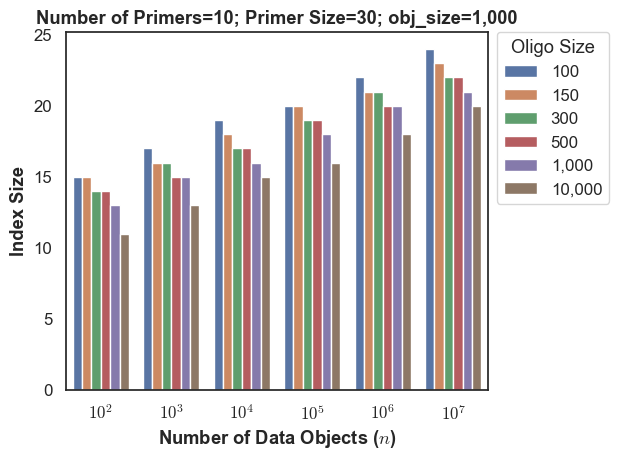

In [31]:
primer_size = 30
n_primers = 10
data_object_size = 1000
df = get_df_fig5bc()
df['Oligo Size Label'] = df['Oligo Size'].apply(lambda x: f"{x:,}")


g = sns.barplot(
    data=df[((df['Primer Size'] == primer_size) & (df["Number of Primers"] == n_primers) & (df['Object Size (MBs)'] == data_object_size) & df['Oligo Size'].isin([100, 150, 300, 500, 1000, 10_000]))],
    x="Number of Objects",
    y="Index Size",
    hue="Oligo Size Label",
    palette="deep",
    #estimator=np.min
)


plt.xlabel("Number of Data Objects ($n$)", fontweight="bold")
plt.ylabel("Index Size", fontweight="bold")
plt.title(
    f"Number of Primers={n_primers:,}; " + f"Primer Size={primer_size}; obj_size={data_object_size:,}",
    fontweight="bold"
)

g.legend(
    title="Oligo Size",
    #loc="upper left",             # anchor legend’s corner
    bbox_to_anchor=(1.02, 1),     # (x, y) in axes fraction coordinates
    borderaxespad=0               # small padding
)

################################################################

ax = g  # get the Axes

cats = sorted(df['Number of Objects'].unique())

# 2) Tell Matplotlib “these are the locations” (0,1,2,…)
ax.set_xticks(range(len(cats)))

# turn them into 10^n labels
powers = [int(np.log10(c)) for c in cats]
ax.set_xticklabels([rf"$10^{{{p}}}$" for p in powers])

plt.tight_layout()
################################################################

save(f"n_primers={n_primers}+primer_size={primer_size}")
plt.show()

## Supplementary Figures 6a-f

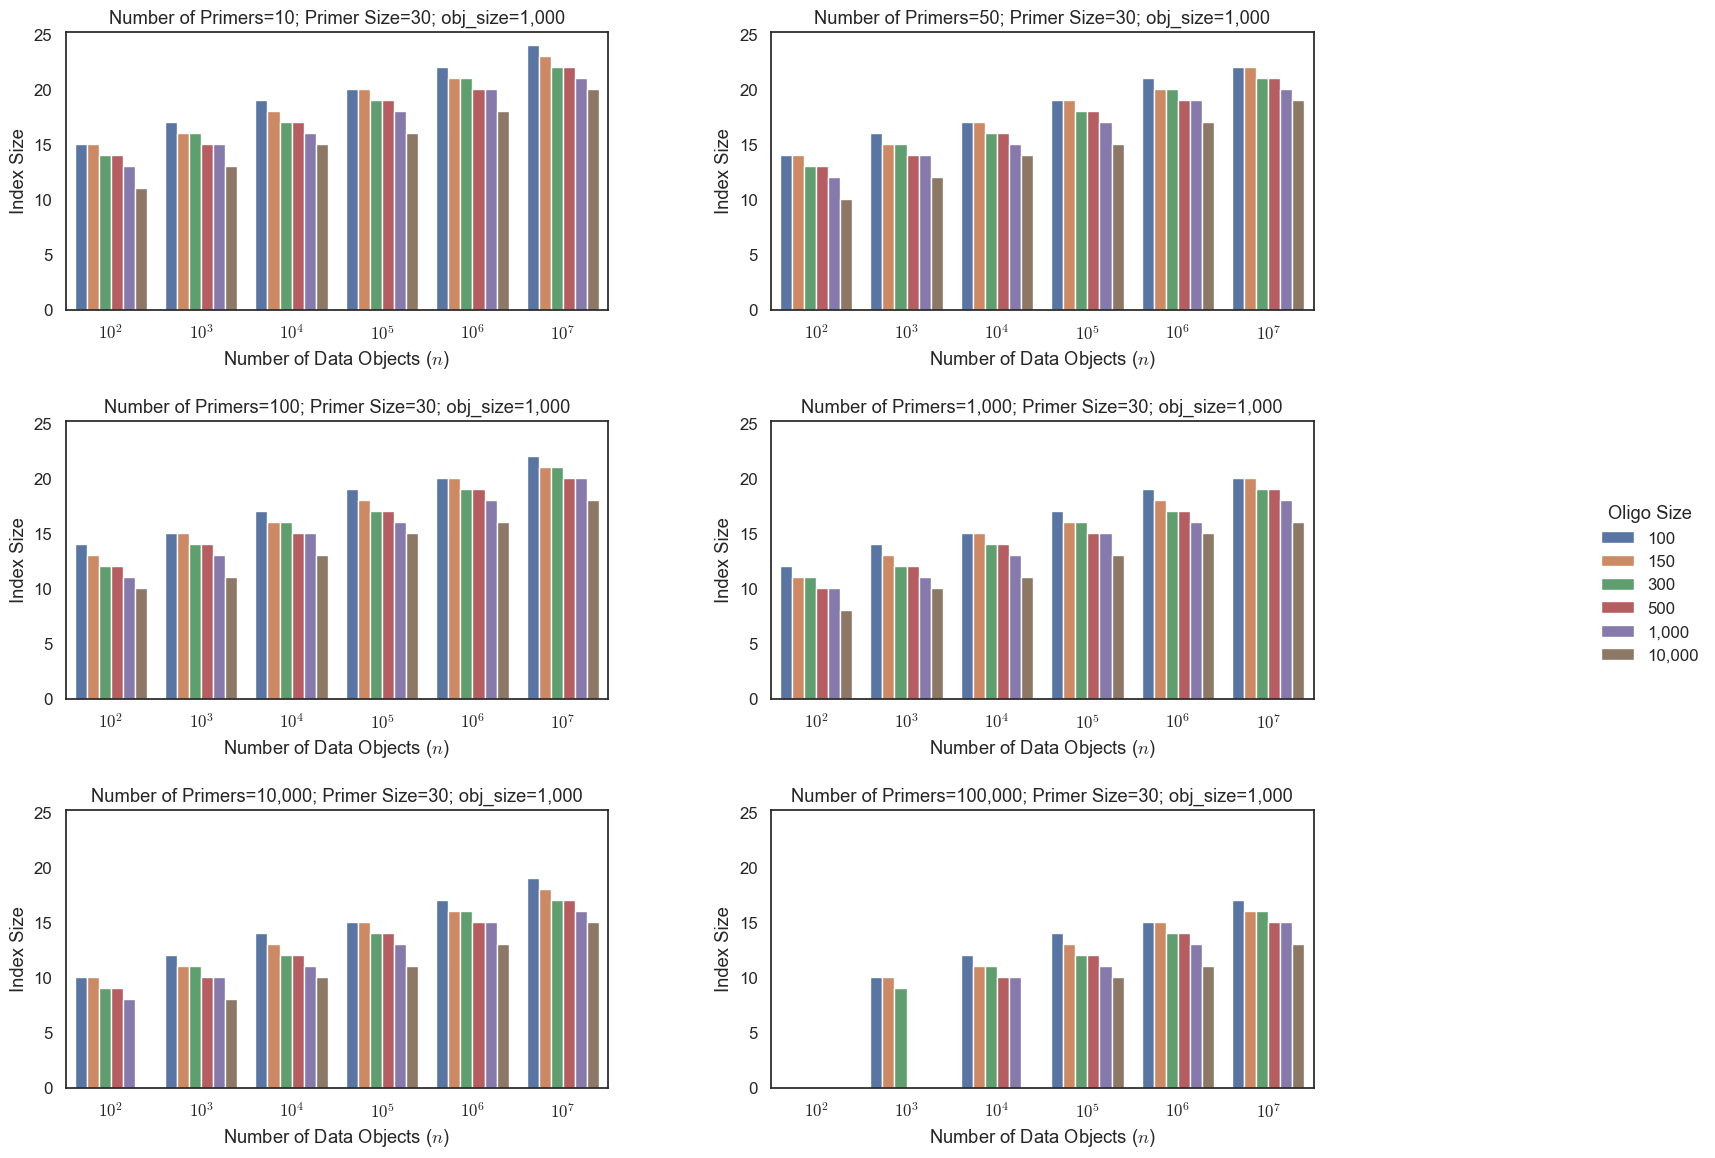

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

df = get_df_fig5bc()
df['Oligo Size Label'] = df['Oligo Size'].apply(lambda x: f"{x:,}")

oligo_keep = [100, 150, 300, 500, 1000, 10_000]

# Correct (row, col) → (primer_size, n_primers, data_object_size)
layout_map = {
    (1, 1): (30, 10, 1000),
    (2, 1): (30, 100, 1000),
    (3, 1): (30, 10_000, 1000),
    (1, 2): (30, 50, 1000),
    (2, 2): (30, 1_000, 1000),
    (3, 2): (30, 100_000, 1000),
}

# --- Figure ---
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2)  # only 2 columns now
axes = {(r, c): fig.add_subplot(gs[r-1, c-1]) for r in range(1, 4) for c in range(1, 3)}

# Common x-categories and tick labels
cats = sorted(df['Number of Objects'].unique())
powers = [int(np.log10(c)) for c in cats]
xtick_labels = [rf"$10^{{{p}}}$" for p in powers]

# Collect legend handles once
handles = labels = None
ylims = []

# Draw plots
for (row, col), (primer_size, n_primers, data_object_size) in layout_map.items():
    ax = axes[(row, col)]

    dff = df[
        (df['Primer Size'] == primer_size) &
        (df['Number of Primers'] == n_primers) &
        (df['Object Size (MBs)'] == data_object_size) &
        (df['Oligo Size'].isin(oligo_keep))
    ]

    g = sns.barplot(
        data=dff,
        x="Number of Objects",
        y="Index Size",
        hue="Oligo Size Label",
        palette="deep",
        ax=ax,
        order=cats,
        dodge=True,
    )

    # Capture legend handles once
    if handles is None:
        handles, labels = ax.get_legend_handles_labels()

    # Remove per-axis legend
    leg = ax.get_legend()
    if leg:
        leg.remove()

    # Fix x axis geometry
    ax.set_xlim(-0.5, len(cats)-0.5)
    ax.set_xticks(range(len(cats)))
    ax.set_xticklabels(xtick_labels)

    ax.set_xlabel("Number of Data Objects ($n$)")
    ax.set_ylabel("Index Size")
    ax.set_title(
        f"Number of Primers={n_primers:,}; Primer Size={primer_size}; obj_size={data_object_size:,}"
    )

    ylims.append(ax.get_ylim())

# Equalize y-limits
if ylims:
    ymin = min(y[0] for y in ylims)
    ymax = max(y[1] for y in ylims)
    for (row, col) in layout_map.keys():
        axes[(row, col)].set_ylim(ymin, ymax)

# Turn off unused axes (none here, but good habit)
for key, ax in axes.items():
    if key not in layout_map:
        ax.set_axis_off()

# Global legend on the right
if handles and labels:
    fig.legend(
        handles,
        labels,
        title="Oligo Size",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
    )

# Adjust spacing to make room for the legend
fig.subplots_adjust(left=0.07, right=0.85, top=0.96, bottom=0.08, wspace=0.3, hspace=0.4)
plt.show()


## Supplementary Figures 7a-f

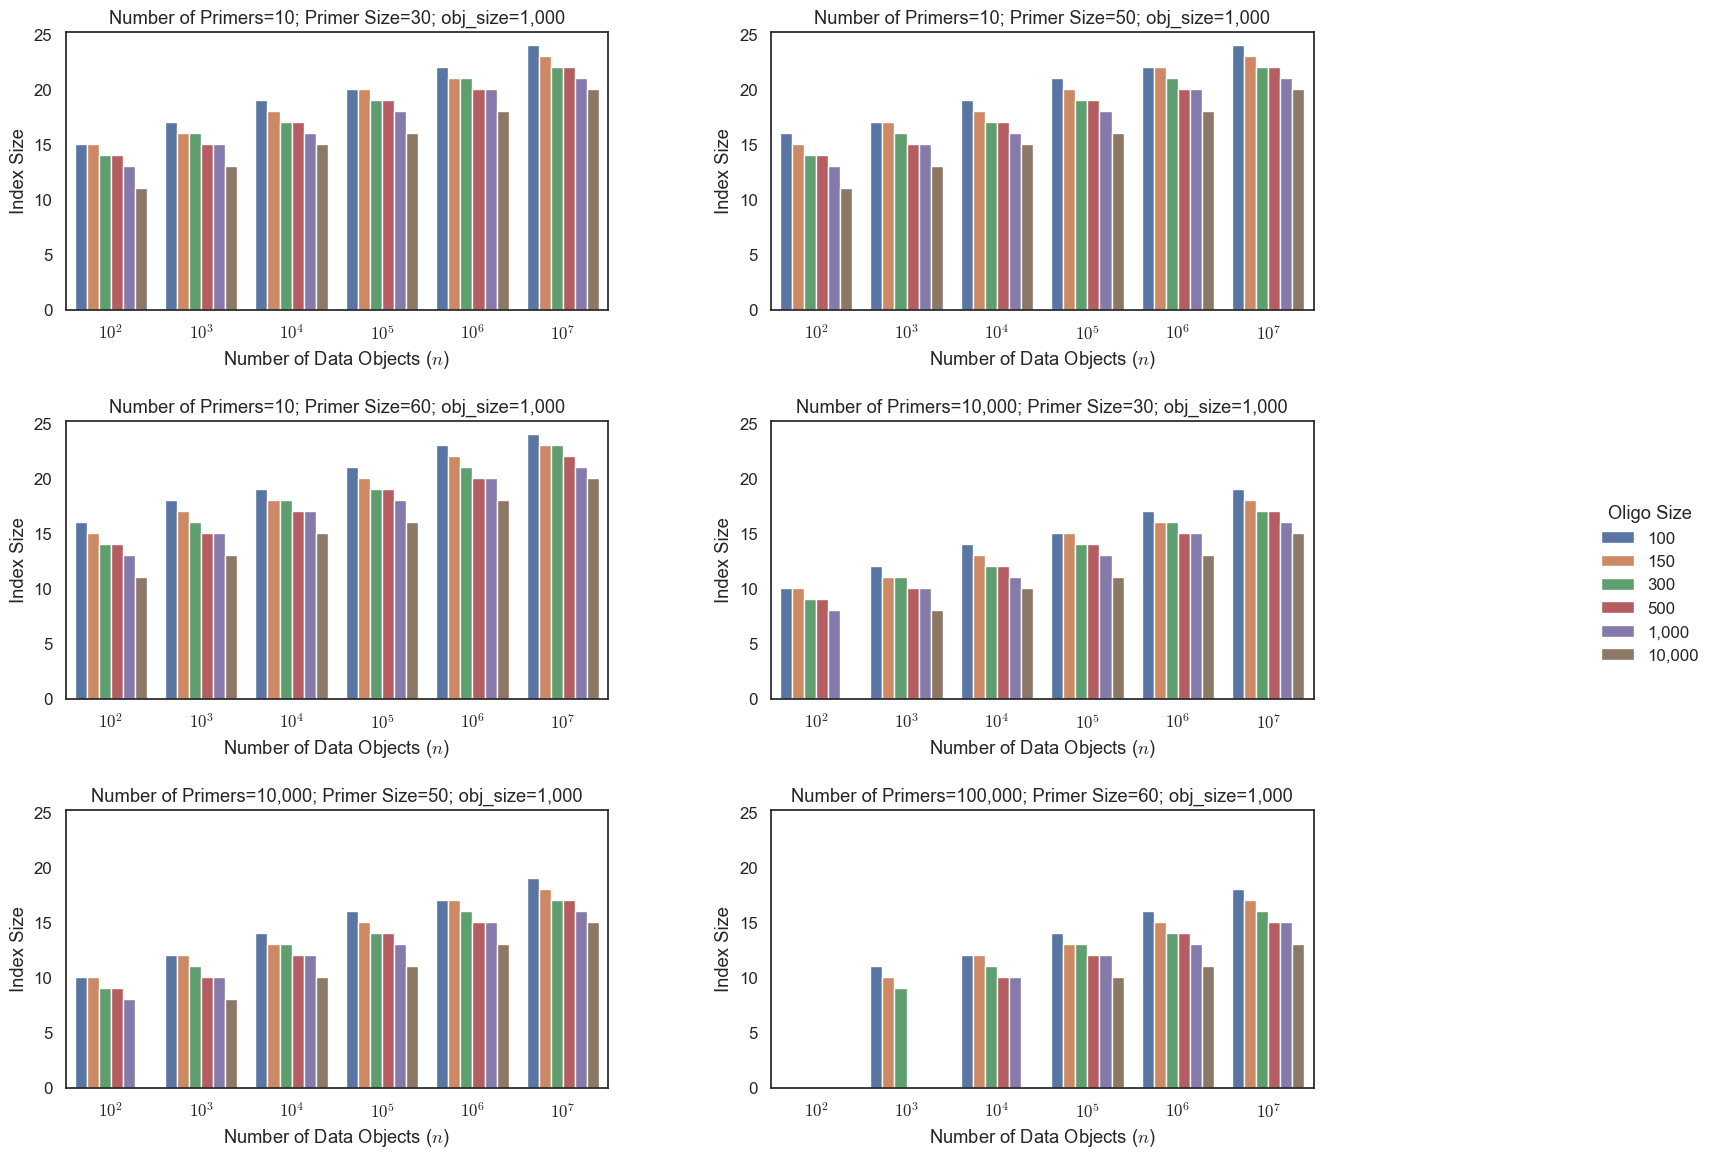

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

df = get_df_fig5bc()
df['Oligo Size Label'] = df['Oligo Size'].apply(lambda x: f"{x:,}")

oligo_keep = [100, 150, 300, 500, 1000, 10_000]

# (row, col) → (primer_size, n_primers, data_object_size)
layout_map = {
    (1, 1): (30, 10, 1000),
    (2, 1): (60, 10, 1000),
    (3, 1): (50, 10_000, 1000),
    (1, 2): (50, 10, 1000),
    (2, 2): (30, 10_000, 1000),
    (3, 2): (60, 100_000, 1000),
}

# --- Figure ---
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2)  # only 2 columns
axes = {(r, c): fig.add_subplot(gs[r-1, c-1]) for r in range(1, 4) for c in range(1, 3)}

# Common x categories and tick labels
cats = sorted(df['Number of Objects'].unique())
powers = [int(np.log10(c)) for c in cats]
xtick_labels = [rf"$10^{{{p}}}$" for p in powers]

# Collect legend handles once
handles = labels = None
ylims = []

# Pass 1: Draw each subplot, collect y-limits
for (row, col), (primer_size, n_primers, data_object_size) in layout_map.items():
    ax = axes[(row, col)]

    dff = df[
        (df['Primer Size'] == primer_size) &
        (df['Number of Primers'] == n_primers) &
        (df['Object Size (MBs)'] == data_object_size) &
        (df['Oligo Size'].isin(oligo_keep))
    ]

    g = sns.barplot(
        data=dff,
        x="Number of Objects",
        y="Index Size",
        hue="Oligo Size Label",
        palette="deep",
        ax=ax,
        order=cats,
        dodge=True,
    )

    # Capture legend handles once (e.g., from the first plot)
    if handles is None:
        handles, labels = ax.get_legend_handles_labels()

    # Remove per-axis legend
    leg = ax.get_legend()
    if leg:
        leg.remove()

    # Force identical x geometry for all panels
    ax.set_xlim(-0.5, len(cats) - 0.5)
    ax.set_xticks(range(len(cats)))
    ax.set_xticklabels(xtick_labels)

    ax.set_xlabel("Number of Data Objects ($n$)")
    ax.set_ylabel("Index Size")
    ax.set_title(
        f"Number of Primers={n_primers:,}; Primer Size={primer_size}; obj_size={data_object_size:,}"
    )

    ylims.append(ax.get_ylim())

# Pass 2: Equalize y-limits across all subplots
if ylims:
    ymin = min(y[0] for y in ylims)
    ymax = max(y[1] for y in ylims)
    for (row, col) in layout_map.keys():
        axes[(row, col)].set_ylim(ymin, ymax)

# Turn off unused cells
for key, ax in axes.items():
    if key not in layout_map:
        ax.set_axis_off()

# --- Global legend on the RIGHT ---
if handles and labels:
    fig.legend(
        handles,
        labels,
        title="Oligo Size",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
    )

# Adjust spacing to leave room for legend
fig.subplots_adjust(left=0.07, right=0.85, top=0.96, bottom=0.08, wspace=0.3, hspace=0.4)
plt.show()


## Supplementary Figure 8a

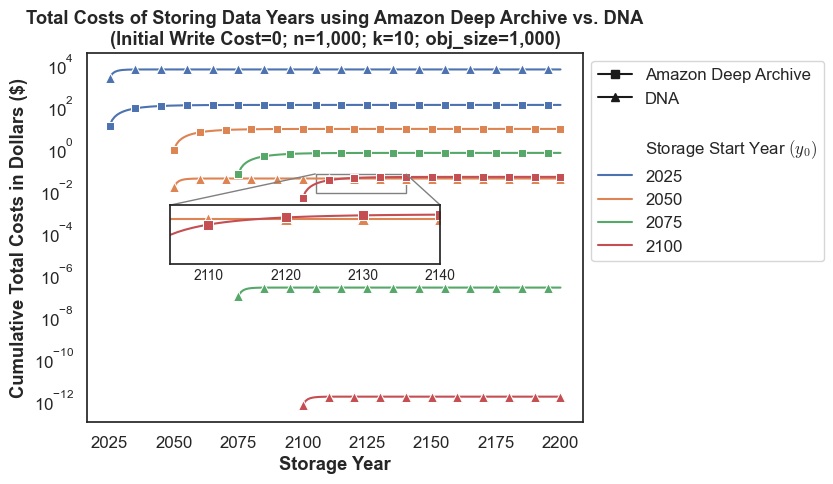

In [10]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
DNA_marker = '^'
tape_marker = "s"

n = 1000
k = 10
obj_size = 1000
if 'df_supp_fig_8' not in globals():
    df_supp_fig_8 = get_df_supp_fig8()

g = sns.lineplot(ax=ax, data=df_supp_fig_8[(df_supp_fig_8['Cost Type'] == 'Total') & (df_supp_fig_8['Current Year'] <= 2200) & (df_supp_fig_8['Start Year'].isin([2025, 2050, 2075, 2100])) & (df_supp_fig_8['k'] == k)], x="Current Year", y="Cumulative Cost", hue="Start Year", style="Storage Tech", palette="deep", markers=[tape_marker, DNA_marker], markevery=10, dashes=False, style_order=['Tape On-premise', 'DNA'])
plt.yscale('log')

for line in g.lines:
        if line.get_marker() == '^':
            line.set_markersize(7)

legend_handles = []

#legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label='Storage Tech'))
legend_handles.append(mlines.Line2D([], [], color='k', marker=tape_marker, linestyle='-', label='Amazon Deep Archive'))
legend_handles.append(mlines.Line2D([], [], color='k', marker=DNA_marker, linestyle='-', label="DNA"))

legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label=''))
legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label=r'Storage Start Year $(y_0)$'))

legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[0], marker=None, linestyle='-', label='2025', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[1], marker=None, linestyle='-', label='2050', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[2], marker=None, linestyle='-', label='2075', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[3], marker=None, linestyle='-', label='2100', markersize=0))
#legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[4], marker=None, linestyle='-', label='2345', markersize=0))
#legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[5], marker=None, linestyle='-', label='2350', markersize=0))

leg = plt.legend(bbox_to_anchor=(1.0, 1.0), loc=2, frameon=True, handles=legend_handles)

first_text = leg.get_texts()[3]
x, y = first_text.get_position()
#first_text.set_position((x - 35, y))
plt.title(
    f"Total Costs of Storing Data Years using Amazon Deep Archive vs. DNA\n"
     f"(Initial Write Cost=0; n={n:,}; k={k}; obj_size={obj_size:,})",
    fontweight="bold"
)
plt.xlabel("Storage Year", fontweight="bold")
plt.ylabel("Cumulative Total Costs in Dollars ($)", fontweight="bold")
####################################################################################################################################
zoom = True
if zoom:

    # 1) Create a 2× zoom inset in the lower‐right corner
    #axins = zoomed_inset_axes(ax, zoom=8, loc='lower right')
    axins = zoomed_inset_axes(
        ax,
        zoom=3,
        loc='upper left',  # corner of the inset to anchor
        bbox_to_anchor=(0.15, 0.61),  # (x, y) in ax.transAxes coords
        bbox_transform=ax.transAxes
    )

    # 2) Re‐plot the same data into the inset (legend turned off)
    z=sns.lineplot(
        data=df_supp_fig_8[
            (df_supp_fig_8['Cost Type'] == 'Total') &
            (df_supp_fig_8['Current Year'] <= 2200) & (df_supp_fig_8['Start Year'].isin([2025, 2050, 2075, 2100]))  & (df_supp_fig_8['k'] == k)
            ],
        x="Current Year", y="Cumulative Cost",
        hue="Start Year", style="Storage Tech",style_order=['Tape On-premise', 'DNA'],
        palette="deep",
        ax=axins,
        legend=False,
        markers=[tape_marker, DNA_marker],
        markevery=10,
        markersize=7,
        dashes=False
    )
    for line in z.lines:
        if line.get_marker() == '^':
            line.set_markersize(9)

    # 3) Match the log scale and zoom region
    axins.set_yscale('log')
    axins.set_xlim(2105, 2140)
    axins.set_ylim(1e-2 * 0.7, 1e-2 * 6)

    # 4) Clean up the inset ticks
    # axins.tick_params(labelleft=False, labelbottom=False)
    axins.tick_params(labelleft=False, labelbottom=True, labelsize=10, pad=-3)

    # 5) Draw the connector box & lines
    mark_inset(
        ax, axins,
        loc1=2, loc2=1,  # corners of the inset to link back
        fc="none", ec="0.5"
    )

    axins.set_xlabel(None)
    axins.set_ylabel(None)
    axins.tick_params(axis='y', which='both', labelleft=False)

####################################################################################################################################

plt.show()

## Supplementary Figure 8b

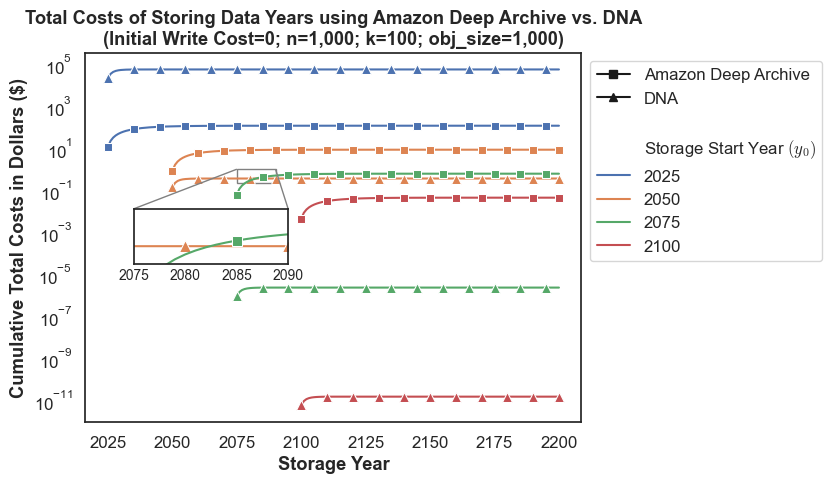

In [11]:
n = 1000
k = 100
obj_size = 1000
if 'df_supp_fig_8' not in globals():
    df_supp_fig_8 = get_df_supp_fig8()
DNA_marker = '^'
tape_marker = "s"
fig, ax = plt.subplots(figsize=(6.4, 4.8))
g=sns.lineplot(ax=ax, data=df_supp_fig_8[(df_supp_fig_8['Cost Type'] == 'Total') & (df_supp_fig_8['Current Year'] <= 2200) & (df_supp_fig_8['Start Year'].isin([2025, 2050, 2075, 2100])) & (df_supp_fig_8['k'] == k)], x="Current Year", y="Cumulative Cost", hue="Start Year", style="Storage Tech", palette="deep", markers=[tape_marker, DNA_marker], markevery=10, dashes=False, style_order=['Tape On-premise', 'DNA'])
plt.yscale('log')

for line in g.lines:
    if line.get_marker() == '^':
        line.set_markersize(7)

legend_handles = []

#legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label='Storage Tech'))
legend_handles.append(mlines.Line2D([], [], color='k', marker=tape_marker, linestyle='-', label='Amazon Deep Archive'))
legend_handles.append(mlines.Line2D([], [], color='k', marker=DNA_marker, linestyle='-', label="DNA"))

legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label=''))
legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label=r'Storage Start Year $(y_0)$'))

legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[0], marker=None, linestyle='-', label='2025', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[1], marker=None, linestyle='-', label='2050', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[2], marker=None, linestyle='-', label='2075', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[3], marker=None, linestyle='-', label='2100', markersize=0))
#legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[4], marker=None, linestyle='-', label='2345', markersize=0))
#legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[5], marker=None, linestyle='-', label='2350', markersize=0))

leg = plt.legend(bbox_to_anchor=(1.0, 1.0), loc=2, frameon=True, handles=legend_handles)

first_text = leg.get_texts()[3]
x, y = first_text.get_position()
#first_text.set_position((x - 35, y))
plt.title(
    f"Total Costs of Storing Data Years using Amazon Deep Archive vs. DNA\n"
     f"(Initial Write Cost=0; n={n:,}; k={k}; obj_size={obj_size:,})",
    fontweight="bold"
)
plt.xlabel("Storage Year", fontweight="bold")
plt.ylabel("Cumulative Total Costs in Dollars ($)", fontweight="bold")
####################################################################################################################################
zoom = True
if zoom:
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

    # … your existing plot code …

    # 1) Create a 2× zoom inset in the lower‐right corner
    #axins = zoomed_inset_axes(ax, zoom=8, loc='lower right')
    axins = zoomed_inset_axes(
        ax,
        zoom=4,
        loc='upper left',  # corner of the inset to anchor
        bbox_to_anchor=(0.08, 0.6),  # (x, y) in ax.transAxes coords
        bbox_transform=ax.transAxes
    )

    # 2) Re‐plot the same data into the inset (legend turned off)
    z=sns.lineplot(
        data=df_supp_fig_8[
            (df_supp_fig_8['Cost Type'] == 'Total') &
            (df_supp_fig_8['Current Year'] <= 2200) & (df_supp_fig_8['Start Year'].isin([2025, 2050, 2075, 2100]))  & (df_supp_fig_8['k'] == k)
            ],
        x="Current Year", y="Cumulative Cost",
        hue="Start Year", style="Storage Tech", style_order=['Tape On-premise', 'DNA'],
        palette="deep",
        ax=axins,
        legend=False,
        markers=[tape_marker, DNA_marker],
        markevery=10,
        markersize=7,
        dashes=False,
    )
    for line in z.lines:
        if line.get_marker() == '^':
            line.set_markersize(9)

    # 3) Match the log scale and zoom region
    axins.set_yscale('log')
    axins.set_xlim(2075, 2090)
    axins.set_ylim(1e-1 * 2.2, 1e-1 * 10)

    # 4) Clean up the inset ticks
    #axins.tick_params(labelleft=False, labelbottom=False)
    axins.tick_params(labelleft=False, labelbottom=True, labelsize=10, pad=-3)

    # 5) Draw the connector box & lines
    mark_inset(
        ax, axins,
        loc1=2, loc2=1,  # corners of the inset to link back
        fc="none", ec="0.5"
    )

    axins.set_xlabel(None)
    axins.set_ylabel(None)
    axins.tick_params(axis='y', which='both', labelleft=False)

####################################################################################################################################

plt.show()

## Supplementary Figure 8c

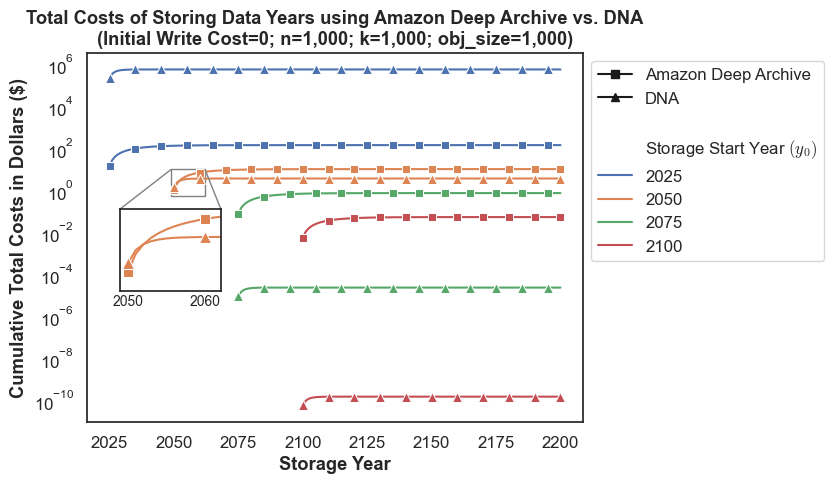

In [13]:
n = 1000
k = 1000
obj_size = 1000
if 'df_supp_fig_8' not in globals():
    df_supp_fig_8 = get_df_supp_fig8()
DNA_marker = '^'
tape_marker = "s"

fig, ax = plt.subplots(figsize=(6.4, 4.8))
g=sns.lineplot(ax=ax, data=df_supp_fig_8[(df_supp_fig_8['Cost Type'] == 'Total') & (df_supp_fig_8['Current Year'] <= 2200) & (df_supp_fig_8['Start Year'].isin([2025, 2050, 2075, 2100])) & (df_supp_fig_8['k'] == k)], x="Current Year", y="Cumulative Cost", hue="Start Year", style="Storage Tech", palette="deep", markers=[tape_marker, DNA_marker], markevery=10, dashes=False, style_order=['Tape On-premise', 'DNA'])
plt.yscale('log')

for line in g.lines:
    if line.get_marker() == '^':
        line.set_markersize(7)

legend_handles = []

#legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label='Storage Tech'))
legend_handles.append(mlines.Line2D([], [], color='k', marker=tape_marker, linestyle='-', label='Amazon Deep Archive'))
legend_handles.append(mlines.Line2D([], [], color='k', marker=DNA_marker, linestyle='-', label="DNA"))

legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label=''))
legend_handles.append(mlines.Line2D([], [], linestyle='', color=None, marker=None, label=r'Storage Start Year $(y_0)$'))

legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[0], marker=None, linestyle='-', label='2025', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[1], marker=None, linestyle='-', label='2050', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[2], marker=None, linestyle='-', label='2075', markersize=0))
legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[3], marker=None, linestyle='-', label='2100', markersize=0))
#legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[4], marker=None, linestyle='-', label='2345', markersize=0))
#legend_handles.append(mlines.Line2D([], [], color=sns.color_palette("deep")[5], marker=None, linestyle='-', label='2350', markersize=0))

leg = plt.legend(bbox_to_anchor=(1.0, 1.0), loc=2, frameon=True, handles=legend_handles)

first_text = leg.get_texts()[3]
x, y = first_text.get_position()
#first_text.set_position((x - 35, y))
plt.title(
    f"Total Costs of Storing Data Years using Amazon Deep Archive vs. DNA\n"
    f"(Initial Write Cost=0; n={n:,}; k={k:,}; obj_size={obj_size:,})",
    fontweight="bold"
)
plt.xlabel("Storage Year", fontweight="bold")
plt.ylabel("Cumulative Total Costs in Dollars ($)", fontweight="bold")
####################################################################################################################################
zoom = True
if zoom:
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

    # … your existing plot code …

    # 1) Create a 2× zoom inset in the lower‐right corner
    #axins = zoomed_inset_axes(ax, zoom=8, loc='lower right')
    axins = zoomed_inset_axes(
        ax,
        zoom=3,
        loc='upper left',  # corner of the inset to anchor
        bbox_to_anchor=(0.05, 0.6),  # (x, y) in ax.transAxes coords
        bbox_transform=ax.transAxes
    )

    # 2) Re‐plot the same data into the inset (legend turned off)
    z=sns.lineplot(
        data=df_supp_fig_8[
            (df_supp_fig_8['Cost Type'] == 'Total') &
            (df_supp_fig_8['Current Year'] <= 2200) & (df_supp_fig_8['Start Year'].isin([2025, 2050, 2075, 2100]))  & (df_supp_fig_8['k'] == k)
            ],
        x="Current Year", y="Cumulative Cost",
        hue="Start Year", style="Storage Tech", style_order=['Tape On-premise', 'DNA'],
        palette="deep",
        ax=axins,
        legend=False,
        markers=[tape_marker, DNA_marker],
        markevery=10,
        markersize=7,
        dashes=False
    )
    for line in z.lines:
        if line.get_marker() == '^':
            line.set_markersize(9)
    # 3) Match the log scale and zoom region
    axins.set_yscale('log')
    axins.set_xlim(2049, 2062)
    axins.set_ylim(1e-1 * 5, 1e-1 * 100)

    # 4) Clean up the inset ticks
    #axins.tick_params(labelleft=False, labelbottom=False)
    axins.tick_params(labelleft=False, labelbottom=True, labelsize=10, pad=-3)

    # 5) Draw the connector box & lines
    mark_inset(
        ax, axins,
        loc1=2, loc2=1,  # corners of the inset to link back
        fc="none", ec="0.5"
    )

    axins.set_xlabel(None)
    axins.set_ylabel(None)
    axins.tick_params(axis='y', which='both', labelleft=False)

####################################################################################################################################

plt.show()